In [1]:
%matplotlib inline

import os

import pandas as pd
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as mdates
import seaborn as sb

In [2]:
file_names = ['AEP_hourly.csv',
              'COMED_hourly.csv',
              'DAYTON_hourly.csv',
              'DEOK_hourly.csv',
              'DOM_hourly.csv',
              'DUQ_hourly.csv',
              'EKPC_hourly.csv',
              'FE_hourly.csv',
              'NI_hourly.csv',
              'PJM_Load_hourly.csv',
              'PJME_hourly.csv',
              'PJMW_hourly.csv']
file_names = ['AEP_hourly.csv']

dfs = []
for file_name in file_names:
    file_path = os.path.join('data', file_name)
    print(f"Reading {file_path}")
    
    df = pd.read_csv(file_path)
    df.rename(columns={df.columns[1]: 'MW'}, inplace=True)
    dfs.append(df)

df = pd.concat(dfs)
df.loc[:, 'Datetime'] = pd.to_datetime(df.loc[:, 'Datetime'])
df = df.sort_values(by='Datetime', ascending=True)

print(f"Total: {len(df)}")
print(df.info())
df.head(10)

Reading data/AEP_hourly.csv
Total: 121273
<class 'pandas.core.frame.DataFrame'>
Int64Index: 121273 entries, 2183 to 116161
Data columns (total 2 columns):
Datetime    121273 non-null datetime64[ns]
MW          121273 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 MB
None


,Datetime,MW
2183,2004-10-01 01:00:00,12379.0
2184,2004-10-01 02:00:00,11935.0
2185,2004-10-01 03:00:00,11692.0
2186,2004-10-01 04:00:00,11597.0
2187,2004-10-01 05:00:00,11681.0
2188,2004-10-01 06:00:00,12280.0
2189,2004-10-01 07:00:00,13692.0
2190,2004-10-01 08:00:00,14618.0
2191,2004-10-01 09:00:00,14903.0
2192,2004-10-01 10:00:00,15118.0


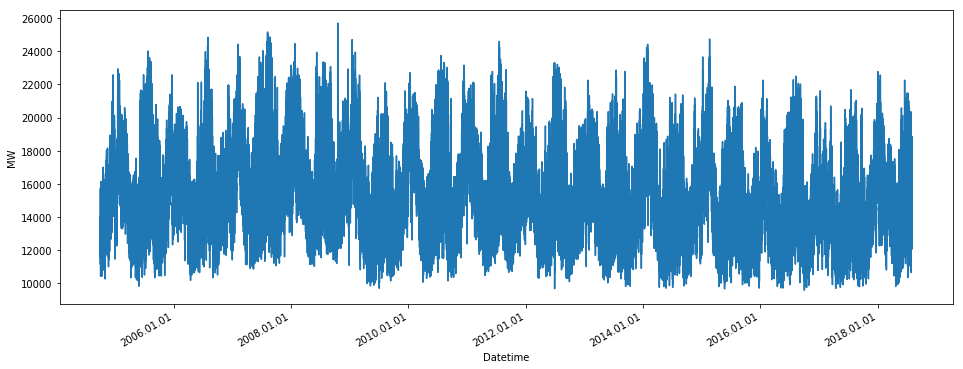

In [3]:
def plot_df(df):
    fig, ax = plt.subplots(figsize=(16, 6))
    sb.lineplot(x='Datetime', y='MW', data=df, ax=ax)

    # assign locator and formatter for the xaxis ticks.
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))

    # put the labels at 45deg since they tend to be too long
    fig.autofmt_xdate()
    plt.show()

plot_df(df)

In [4]:
import tensorflow as tf

def timestamp_series_to_millisecs(series):
    return (series.astype(np.int64) // 10**9).astype(np.float64)

def dense(x, unit, act=tf.nn.relu):
    initializer = tf.contrib.layers.xavier_initializer()
    
    return tf.layers.dense(x, unit, activation=act)

def build_network(normalize_info, mode=0, poly_dim=6):
    x, y = tf.placeholder(np.float64, (None, 1)), tf.placeholder(np.float64, (None, 1))
    min_x, max_x, min_y, max_y = normalize_info
    
    norm_x = normalize(x, max_x, min_x, 1, -1)
    norm_y = normalize(y, max_y, min_y, 1, -1)
    
    if mode == 0:
        norm_out = norm_x
        norm_out = dense(norm_out, 500)
        norm_out = dense(norm_out, 200)
        norm_out = dense(norm_out, 100)
        norm_out = dense(norm_out, 45)
        norm_out = dense(norm_out, 1, act=None)
    elif mode == 1:
        norm_outs = []
        for degree in range(poly_dim, 0, -1):
            norm_outs.append(dense(tf.pow(norm_x, degree), 1, act=None))
        norm_out = tf.reduce_sum(norm_outs, axis=0)
    elif mode == 2:
        norm_outs = []
        for degree in range(poly_dim, 0, -1):
            coef = tf.Variable(0, dtype=tf.float64)
            norm_outs.append(coef * tf.pow(norm_x, degree))
        norm_out = tf.reduce_sum(norm_outs, axis=0)
    
    loss = tf.losses.mean_squared_error(norm_y, norm_out)
    minimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
    
    out = denormalize(norm_out, max_y, min_y, 1, -1)

    return x, y, out, loss, minimizer

def create_dataset(df, train_ratio):
    def preprocess(data):
        x = data.iloc[:, 0].values.reshape((-1, 1))
        y = data.iloc[:, 1].values.reshape((-1, 1))
        x = timestamp_series_to_millisecs(x)
        
        return x, y
    
    data_count = len(df)
    train_count = int(data_count * train_ratio)

    train_indices = np.random.choice(data_count, size=train_count, replace=False)
    train_mask = np.full(data_count, False)
    train_mask[train_indices] = True

    test_mask = np.full(data_count, True)
    test_mask[train_indices] = False
    
    ts = timestamp_series_to_millisecs(df.iloc[:, 0])
    watts = df.iloc[:, 1]
    normalize_info = ts.min(), ts.max(), watts.min(), watts.max()
    
    train_set = df.iloc[train_mask]
    test_set = df.iloc[test_mask]
    
    train_x, train_y = preprocess(train_set)
    test_x, test_y = preprocess(test_set)
    
    return train_x, train_y, test_x, test_y, normalize_info

def create_dummy_dataset():
    def f(x):
#         return 1e-4 * (3*x**5 + 7*x**4 + 4*x**3 + x**2 + x)
        return (x - 10) * (x + 10) * (x - 5) * (x + 5) * (x - 7) * (x + 7)
    
    x_train = 20 * np.random.rand(9000) - 10
    y_train = f(x_train)

    x_test = np.linspace(-10, 10, num=100)
    y_test = f(x_test)
    
    x_train = x_train.reshape((-1, 1))
    y_train = y_train.reshape((-1, 1))
    x_test = x_test.reshape((-1, 1))
    y_test = y_test.reshape((-1, 1))
    
    xs = np.concatenate([x_train, x_test])
    ys = np.concatenate([y_train, y_test])
    normalize_info = xs.min(), xs.max(), ys.min(), ys.max()
    
    return x_train, y_train, x_test, y_test, normalize_info

def create_batch(x, y, size):
    mask = np.random.choice(len(x), size=size, replace=False)
    
    return x[mask], y[mask]

def normalize_batches(batch_x, batch_y):
    x_ptp = batch_x.ptp()
    y_ptp = batch_y.ptp()
    batch_x = normalize(batch_x, batch_x.min(), batch_x.max(), 0, (x_ptp // 10))
    batch_y = normalize(batch_y, batch_y.min(), batch_y.max(), 0, (y_ptp // 10))
    
    return batch_x, batch_y

def normalize(t, high, low, norm_high, norm_low):
    t = (t - low) / (high - low)
    t = t * (norm_high - norm_low) + norm_low

    return t

def denormalize(t, high, low, norm_high, norm_low):
    return normalize(t, norm_high, norm_low, high, low)

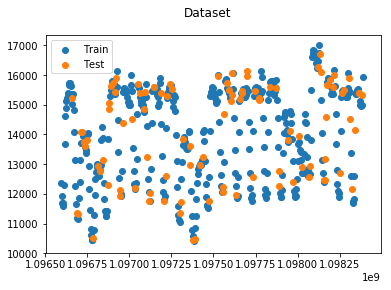

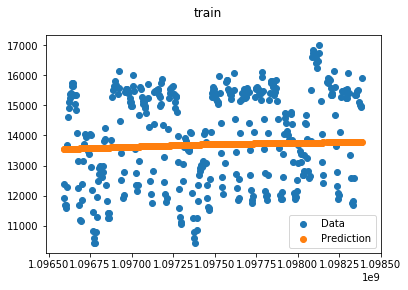

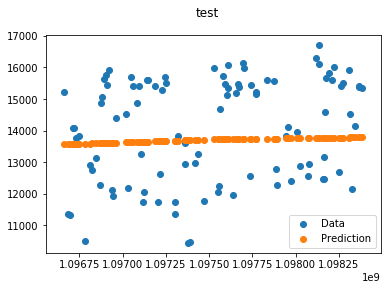

Loss(0): 0.26536545157432556


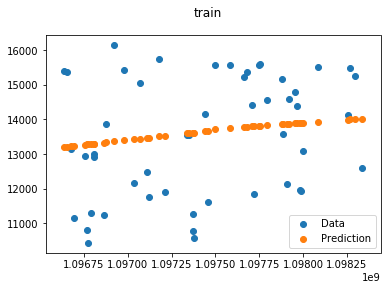

Loss(100): 0.19874049723148346
Loss(200): 0.17400763928890228
Loss(300): 0.18986408412456512
Loss(400): 0.21193042397499084
Loss(500): 0.2310282588005066
Loss(600): 0.1896226555109024
Loss(700): 0.19360697269439697
Loss(800): 0.2271719127893448
Loss(900): 0.18874810636043549
Loss(1000): 0.17065097391605377


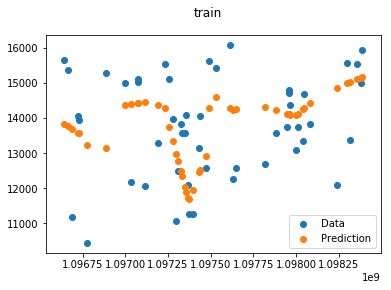

Loss(1100): 0.18211629986763
Loss(1200): 0.2211458384990692
Loss(1300): 0.15783342719078064
Loss(1400): 0.1505032181739807
Loss(1500): 0.1530321091413498
Loss(1600): 0.1624605357646942
Loss(1700): 0.14792029559612274
Loss(1800): 0.1532929241657257
Loss(1900): 0.1530524343252182
Loss(2000): 0.15382391214370728


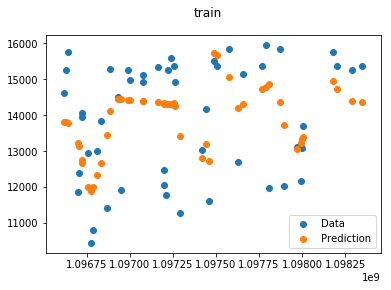

Loss(2100): 0.15534913539886475
Loss(2200): 0.17560319602489471
Loss(2300): 0.16977962851524353
Loss(2400): 0.1298777312040329
Loss(2500): 0.14481787383556366
Loss(2600): 0.15436145663261414
Loss(2700): 0.15503686666488647
Loss(2800): 0.1079106330871582
Loss(2900): 0.10912305861711502
Loss(3000): 0.1366061270236969


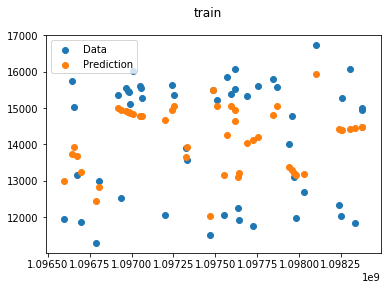

Loss(3100): 0.1564272940158844
Loss(3200): 0.11308413743972778
Loss(3300): 0.1254555881023407
Loss(3400): 0.14099255204200745
Loss(3500): 0.11873023957014084
Loss(3600): 0.11440378427505493
Loss(3700): 0.09433098882436752
Loss(3800): 0.15939195454120636
Loss(3900): 0.10816121846437454
Loss(4000): 0.10946731269359589


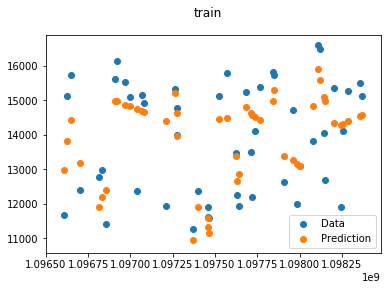

Loss(4100): 0.10779858380556107
Loss(4200): 0.10366224497556686
Loss(4300): 0.11143254488706589
Loss(4400): 0.14925412833690643
Loss(4500): 0.10702654719352722
Loss(4600): 0.12443910539150238
Loss(4700): 0.11064454913139343
Loss(4800): 0.0948580652475357
Loss(4900): 0.10129045695066452
Loss(5000): 0.1015385314822197


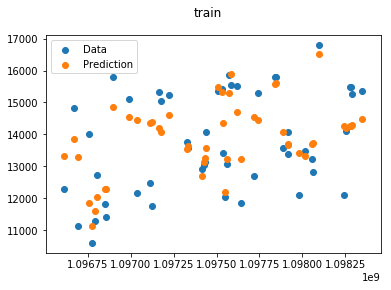

Loss(5100): 0.07927568256855011
Loss(5200): 0.12686008214950562
Loss(5300): 0.08546046912670135
Loss(5400): 0.12494152039289474
Loss(5500): 0.10154574364423752
Loss(5600): 0.09989595413208008
Loss(5700): 0.14494819939136505
Loss(5800): 0.10399506241083145
Loss(5900): 0.10317686200141907
Loss(6000): 0.1494031399488449


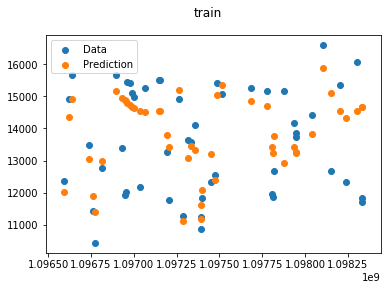

Loss(6100): 0.11213821172714233
Loss(6200): 0.0931522473692894
Loss(6300): 0.0954747423529625
Loss(6400): 0.06897472590208054
Loss(6500): 0.1040605828166008
Loss(6600): 0.07137948274612427
Loss(6700): 0.08269330859184265
Loss(6800): 0.08602572232484818
Loss(6900): 0.08403012156486511
Loss(7000): 0.06959458440542221


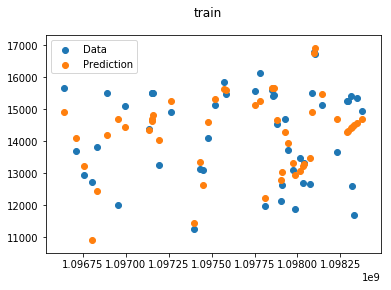

Loss(7100): 0.05859795957803726
Loss(7200): 0.08224405348300934
Loss(7300): 0.07010055333375931
Loss(7400): 0.07873563468456268
Loss(7500): 0.10232918709516525
Loss(7600): 0.05569763481616974
Loss(7700): 0.068604476749897
Loss(7800): 0.06320223957300186
Loss(7900): 0.06184820830821991
Loss(8000): 0.043351780623197556


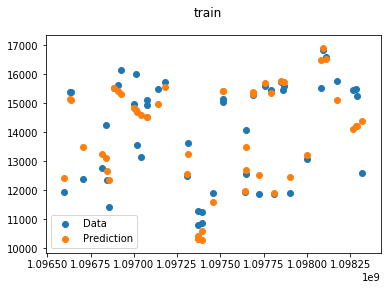

Loss(8100): 0.03069939650595188
Loss(8200): 0.048419658094644547
Loss(8300): 0.060352105647325516
Loss(8400): 0.07201125472784042
Loss(8500): 0.058450933545827866
Loss(8600): 0.046839505434036255
Loss(8700): 0.0747319683432579
Loss(8800): 0.0463915690779686
Loss(8900): 0.04224085435271263
Loss(9000): 0.06510353088378906


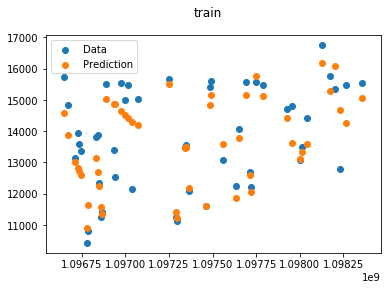

Loss(9100): 0.09924763441085815
Loss(9200): 0.08631566166877747
Loss(9300): 0.08432886749505997
Loss(9400): 0.05956047400832176
Loss(9500): 0.05560579150915146
Loss(9600): 0.06319249421358109
Loss(9700): 0.05561605095863342
Loss(9800): 0.061901990324258804
Loss(9900): 0.066362164914608
Loss(10000): 0.04082797095179558


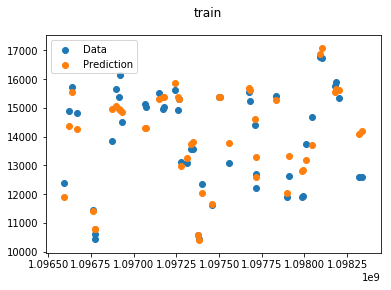

Loss(10100): 0.04437623918056488
Loss(10200): 0.05189479887485504
Loss(10300): 0.056663937866687775
Loss(10400): 0.07503785938024521
Loss(10500): 0.03244302049279213
Loss(10600): 0.046329811215400696
Loss(10700): 0.06427925825119019
Loss(10800): 0.029993588104844093
Loss(10900): 0.07554835826158524
Loss(11000): 0.06670750677585602


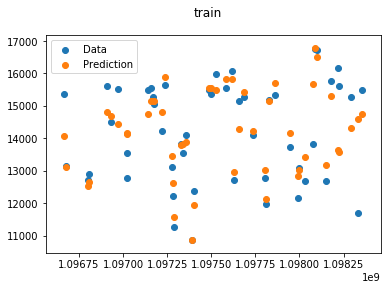

Loss(11100): 0.07649858295917511
Loss(11200): 0.049993399530649185
Loss(11300): 0.03889012709259987
Loss(11400): 0.03626727685332298
Loss(11500): 0.0692978948354721
Loss(11600): 0.061675142496824265
Loss(11700): 0.05702606216073036
Loss(11800): 0.04337659850716591
Loss(11900): 0.03930456191301346
Loss(12000): 0.09594009071588516


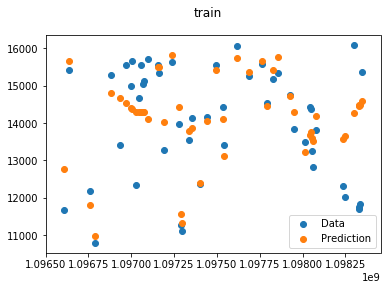

Loss(12100): 0.0340142548084259
Loss(12200): 0.03642869368195534
Loss(12300): 0.05895983800292015
Loss(12400): 0.04361468926072121
Loss(12500): 0.047356437891721725
Loss(12600): 0.07560902833938599
Loss(12700): 0.056139025837183
Loss(12800): 0.051054831594228745
Loss(12900): 0.07555189728736877
Loss(13000): 0.039278820157051086


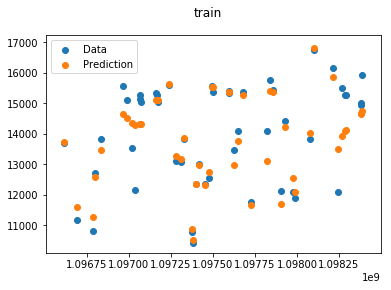

Loss(13100): 0.0595538504421711
Loss(13200): 0.067314513027668
Loss(13300): 0.03544909134507179
Loss(13400): 0.04098198562860489
Loss(13500): 0.04575377330183983
Loss(13600): 0.076105035841465
Loss(13700): 0.06642211973667145
Loss(13800): 0.06088567152619362
Loss(13900): 0.07777669280767441
Loss(14000): 0.05527428165078163


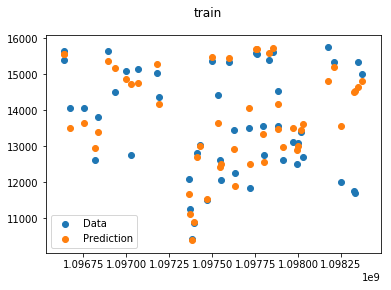

Loss(14100): 0.043955106288194656
Loss(14200): 0.04074348136782646
Loss(14300): 0.031027518212795258
Loss(14400): 0.07195301353931427
Loss(14500): 0.07284145057201385
Loss(14600): 0.08359196037054062
Loss(14700): 0.0580873042345047
Loss(14800): 0.06353133916854858
Loss(14900): 0.0321878083050251
Loss(15000): 0.08152145147323608


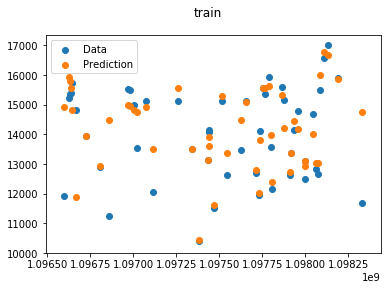

Loss(15100): 0.038770582526922226
Loss(15200): 0.08242464810609818
Loss(15300): 0.04613283649086952
Loss(15400): 0.055509649217128754
Loss(15500): 0.08794371783733368
Loss(15600): 0.04545918107032776
Loss(15700): 0.03049396350979805
Loss(15800): 0.0532209537923336
Loss(15900): 0.06118381395936012
Loss(16000): 0.055649999529123306


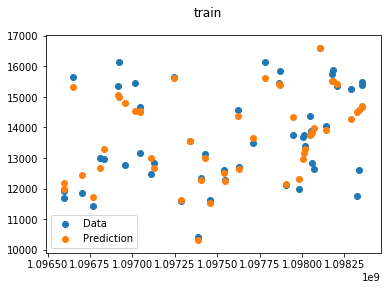

Loss(16100): 0.053791385143995285
Loss(16200): 0.05746322125196457
Loss(16300): 0.0388014018535614
Loss(16400): 0.052132442593574524
Loss(16500): 0.03984692320227623
Loss(16600): 0.05263492465019226
Loss(16700): 0.08489415049552917
Loss(16800): 0.054038673639297485
Loss(16900): 0.03947791829705238
Loss(17000): 0.06383492797613144


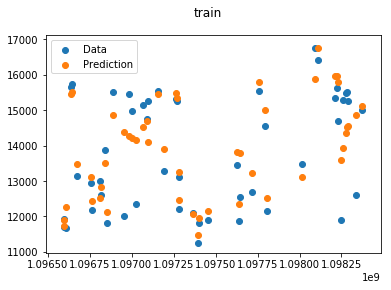

Loss(17100): 0.05642223730683327
Loss(17200): 0.05046316236257553
Loss(17300): 0.03658606484532356
Loss(17400): 0.06465237587690353
Loss(17500): 0.05576176568865776
Loss(17600): 0.033906977623701096
Loss(17700): 0.03545026481151581
Loss(17800): 0.025343574583530426
Loss(17900): 0.04001310467720032
Loss(18000): 0.03735501691699028


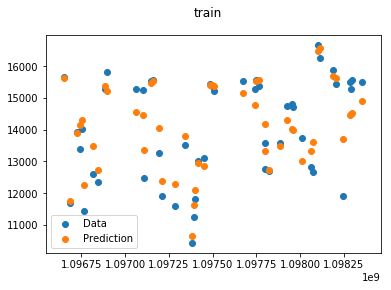

Loss(18100): 0.02245267480611801
Loss(18200): 0.03339631110429764
Loss(18300): 0.05983037129044533
Loss(18400): 0.04777541011571884
Loss(18500): 0.05600962042808533
Loss(18600): 0.03485358506441116
Loss(18700): 0.0583890900015831
Loss(18800): 0.03631994500756264
Loss(18900): 0.029142998158931732
Loss(19000): 0.05710913613438606


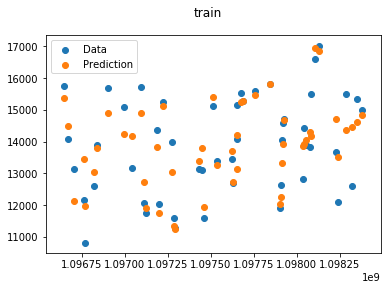

Loss(19100): 0.03828497231006622
Loss(19200): 0.04235614463686943
Loss(19300): 0.02540408819913864
Loss(19400): 0.029676290228962898
Loss(19500): 0.05105031654238701
Loss(19600): 0.043152619153261185
Loss(19700): 0.0643305554986
Loss(19800): 0.04298292100429535
Loss(19900): 0.09103867411613464


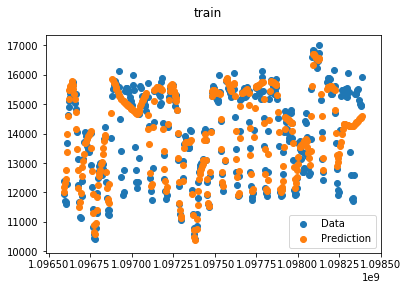

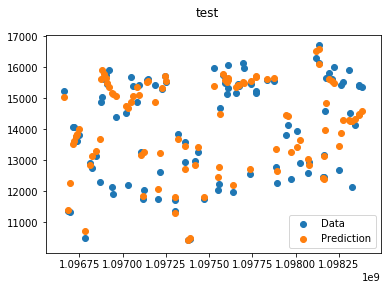

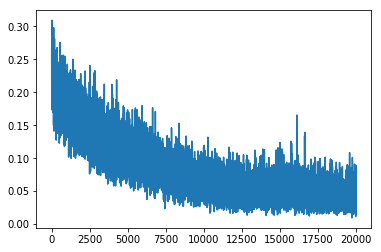

In [5]:
# TODO: This dataset may not suit for regression problem. See what "overfit" means on curve fitting.
train_x, train_y, test_x, test_y, normalize_info = create_dataset(df.iloc[:500], 0.8)
# train_x, train_y, test_x, test_y, normalize_info = create_dummy_dataset()

plt.scatter(train_x, train_y, label='Train')
plt.scatter(test_x, test_y, label='Test')
plt.suptitle('Dataset')
plt.legend()
plt.show()

loss_history = []

tf.reset_default_graph()
with tf.Session() as sess:
    x, y, out, loss, minimizer = build_network(normalize_info, mode=0, poly_dim=5)

    def predict(sess, x_batch, y_batch, title):
        test_out = sess.run(out, feed_dict={x: x_batch})
        
        plt.scatter(x_batch, y_batch, label='Data')
        plt.scatter(x_batch, test_out, label='Prediction')
        plt.suptitle(title)
        plt.legend()
        plt.show()
    
    sess.run(tf.global_variables_initializer())
    
    predict(sess, train_x, train_y, 'train')
    predict(sess, test_x, test_y, 'test')
    for i in range(20000):
        batch_x, batch_y = create_batch(train_x, train_y, 50)
        
        loss_res, _ = sess.run([loss, minimizer], feed_dict={x: batch_x, y: batch_y})
        loss_history.append(loss_res)
        
        if i % 100 == 0:
            print(f"Loss({i}): {loss_res}")
        if i % 1000 == 0:
            predict(sess, batch_x, batch_y, 'train')
    
    predict(sess, train_x, train_y, 'train')
    predict(sess, test_x, test_y, 'test')
    plt.plot(loss_history)
    plt.show()

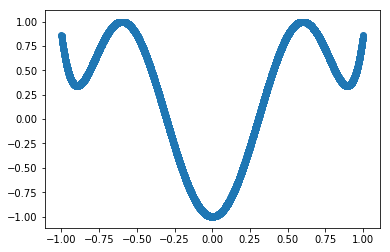

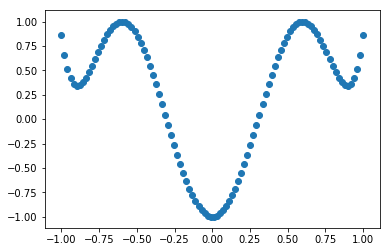

Epoch 1/40
9000/9000 [==============================] - 1s 57us/step - loss: 0.3188
Epoch 2/40
9000/9000 [==============================] - 0s 28us/step - loss: 0.2119
Epoch 3/40
9000/9000 [==============================] - 0s 26us/step - loss: 0.1518
Epoch 4/40
9000/9000 [==============================] - 0s 25us/step - loss: 0.1234
Epoch 5/40
9000/9000 [==============================] - 0s 28us/step - loss: 0.1049
Epoch 6/40
9000/9000 [==============================] - 0s 27us/step - loss: 0.0897
Epoch 7/40
9000/9000 [==============================] - 0s 27us/step - loss: 0.0762
Epoch 8/40
9000/9000 [==============================] - 0s 27us/step - loss: 0.0633
Epoch 9/40
9000/9000 [==============================] - 0s 26us/step - loss: 0.0513
Epoch 10/40
9000/9000 [==============================] - 0s 28us/step - loss: 0.0409
Epoch 11/40
9000/9000 [==============================] - 0s 27us/step - loss: 0.0324
Epoch 12/40
9000/9000 [==============================] - 0s 25us/step - lo

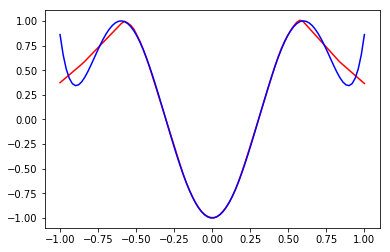

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

# x_train, y_train, x_test, y_test, _ = create_dataset(df.iloc[:26*4], 0.8)
x_train, y_train, x_test, y_test, _ = create_dummy_dataset()

xs, ys = np.concatenate([x_train, x_test]), np.concatenate([y_train, y_test])
x_train = normalize(x_train, xs.max(), xs.min(), 1, -1)
x_test = normalize(x_test, xs.max(), xs.min(), 1, -1)
y_train = normalize(y_train, ys.max(), ys.min(), 1, -1)
y_test = normalize(y_test, ys.max(), ys.min(), 1, -1)

plt.scatter(x_train, y_train)
plt.show()
plt.scatter(x_test, y_test)
plt.show()

model = Sequential()
model.add(Dense(units=200, input_dim=1))
model.add(Activation('relu'))
model.add(Dense(units=100, input_dim=1))
model.add(Activation('relu'))
model.add(Dense(units=45))
model.add(Activation('relu'))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error',
              optimizer='sgd')

model.fit(x_train, y_train, epochs=40, batch_size=50, verbose=1)

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=100)

classes = model.predict(x_test, batch_size=1)

test=x_test.reshape(-1)
plt.plot(test,classes,c='r')
plt.plot(test,y_test,c='b')
plt.show()